# Resume Job Matching Project

Runtime Environment

In [1]:
!pip install -q kaggle
!pip install -q transformers sentence-transformers

Import Libraries

In [2]:
import os
import ast
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import cosine_similarity
from sentence_transformers import SentenceTransformer, InputExample, losses, models
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

Kaggle Setup

In [ ]:
os.environ["WANDB_DISABLED"] = "true"
files.upload()

In [4]:
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
os.chmod('/root/.kaggle/kaggle.json', 600)

Dataset

In [5]:
!kaggle datasets download -d saugataroyarghya/resume-dataset
!unzip resume-dataset.zip -d resume_data
print("Files in dataset folder:", os.listdir("resume_data"))

Dataset URL: https://www.kaggle.com/datasets/saugataroyarghya/resume-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/3.69M [00:00<?, ?B/s]
100% 3.69M/3.69M [00:00<00:00, 281MB/s]
Archive:  resume-dataset.zip
  inflating: resume_data/resume_data.csv  
Files in dataset folder: ['resume_data.csv']


In [6]:
df = pd.read_csv("resume_data/resume_data.csv")

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (9544, 35)


,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,online_links,issue_dates,expiry_dates,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.850000
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.750000
2,NaN,NaN,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],...,NaN,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667
3,NaN,To obtain a position in a fast-paced business ...,"['accounts payables', 'accounts receivables', ...","['Martinez Adult Education, Business Training ...",['Computer Applications Specialist Certificate...,['2008'],[None],[None],['Computer Applications'],"['Company Name ï¼ City , State', 'Company Name...",...,NaN,NaN,NaN,Business Development Executive,Bachelor/Honors,1 to 3 years,Age 22 to 30 years,Apparel Sourcing\nQuality Garment Sourcing\nRe...,Fast typing skill\nIELTSInternet browsing & on...,0.760000
4,NaN,Professional accountant with an outstanding wo...,"['Analytical reasoning', 'Compliance testing k...",['Kent State University'],['Bachelor of Business Administration'],[None],['3.84'],[None],['Accounting'],"['Company Name', 'Company Name', 'Company Name...",...,[None],[None],"['February 15, 2021']",Senior iOS Engineer,Bachelor of Science (BSc) in Computer Science,At least 4 years,NaN,iOS Lifecycle\nRequirement Analysis\nNative Fr...,iOS\niOS App Developer\niOS Application Develo...,0.650000


In [7]:
print("Features:", df.columns)
print("Missing values:", df.isnull().sum())

Features: Index(['address', 'career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results', 'result_types',
       'major_field_of_studies', 'professional_company_names', 'company_urls',
       'start_dates', 'end_dates', 'related_skils_in_job', 'positions',
       'locations', 'responsibilities', 'extra_curricular_activity_types',
       'extra_curricular_organization_names',
       'extra_curricular_organization_links', 'role_positions', 'languages',
       'proficiency_levels', 'certification_providers', 'certification_skills',
       'online_links', 'issue_dates', 'expiry_dates', '﻿job_position_name',
       'educationaL_requirements', 'experiencere_requirement',
       'age_requirement', 'responsibilities.1', 'skills_required',
       'matched_score'],
      dtype='object')
Missing values: address                                8760
career_objective                       4804
skills                                   56
e

In [8]:
print("Dataset information and statistics:")
print(df.describe(include='all').T)

Dataset information and statistics:
                                      count unique  \
address                                 784     28   
career_objective                       4740    171   
skills                                 9488    340   
educational_institution_name           9460    328   
degree_names                           9460    180   
passing_years                          9460    149   
educational_results                    9460     78   
result_types                           9460     30   
major_field_of_studies                 9460    210   
professional_company_names             9460    199   
company_urls                           9460     16   
start_dates                            9460    252   
end_dates                              9460    246   
related_skils_in_job                   9460    298   
positions                              9460    301   
locations                              9460     86   
responsibilities                       9544   

Preprocess Dataset

In [9]:
def clean_text_column(text):
    if pd.isna(text) or text in ['[None]', '[\'N/A\']', '[None, None]']:
        return ''
    try:
        text = ast.literal_eval(text)
        if isinstance(text, list):
            text = " ".join([str(item) for item in text])
        elif isinstance(text, str):
            pass
    except:
        pass
    text = str(text).replace('\n', ' ').replace('\r', ' ')
    text = text.replace("'", "").replace("[", "").replace("]", "")
    return text.strip().lower()

resume_text_cols = ['skills', 'career_objective', 'professional_company_names', 'responsibilities']
for col in resume_text_cols:
    df[col] = df[col].apply(clean_text_column)

fill_cols = ['educational_institution_name', 'degree_names', 'passing_years', 'major_field_of_studies']
df[fill_cols] = df[fill_cols].fillna('')


Device

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## First Model (MiniLM)

Model

In [11]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
def embed_text(text_list):
    embeddings = model.encode(text_list, convert_to_tensor=True)
    return embeddings

In [13]:
df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=False)
job_text_fields = ['job_position_name','educationaL_requirements','experiencere_requirement','responsibilities.1','skills_required']

df[job_text_fields] = df[job_text_fields].fillna("")
df['job_description_combined'] = df[job_text_fields].agg(' '.join, axis=1)

resume_text_fields = ['career_objective','skills','educational_institution_name','degree_names','passing_years','major_field_of_studies','professional_company_names','responsibilities']
df[resume_text_fields] = df[resume_text_fields].fillna("")
df['resume_combined'] = df[resume_text_fields].agg(' '.join, axis=1)

Generate Embeddings

In [14]:
resume_embeddings = model.encode(
    df['resume_combined'].tolist(),
    show_progress_bar=True,
    convert_to_tensor=True
)

job_embeddings = model.encode(
    df['job_description_combined'].tolist(),
    show_progress_bar=True,
    convert_to_tensor=True
)

print(f"Shape of Job Embeddings: {job_embeddings.shape}")
print(f"Shape of Resume Embeddings: {resume_embeddings.shape}")

Batches:   0%|          | 0/299 [00:00<?, ?it/s]

Batches:   0%|          | 0/299 [00:00<?, ?it/s]

Shape of Job Embeddings: torch.Size([9544, 384])
Shape of Resume Embeddings: torch.Size([9544, 384])


Cosine Similarity Score

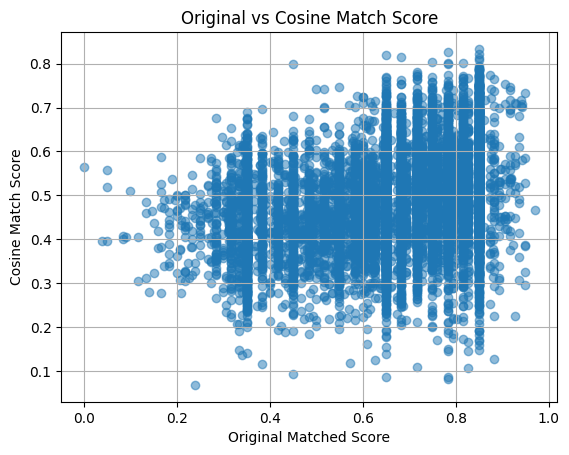

In [15]:
cosine_match_scores = cosine_similarity(resume_embeddings, job_embeddings)
df['cosine_match_score'] = cosine_match_scores.cpu().numpy()


plt.scatter(df['matched_score'], df['cosine_match_score'], alpha=0.5)
plt.xlabel("Original Matched Score")
plt.ylabel("Cosine Match Score")
plt.title("Original vs Cosine Match Score")
plt.grid(True)
plt.show()

Train-Test Split

In [16]:
X_tensor = torch.cat([resume_embeddings, job_embeddings], dim=1).to(device)
y_tensor = torch.tensor(df['matched_score'].values, dtype=torch.float32).unsqueeze(1).to(device)

split_idx = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

### Simple Neural Network Model

MLP

In [17]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 4.2436
Epoch 2, Loss: 1.7421
Epoch 3, Loss: 1.5514
Epoch 4, Loss: 1.3825
Epoch 5, Loss: 1.2469
Epoch 6, Loss: 1.1750
Epoch 7, Loss: 1.1190
Epoch 8, Loss: 1.0434
Epoch 9, Loss: 0.9996
Epoch 10, Loss: 0.9820
Epoch 11, Loss: 0.9249
Epoch 12, Loss: 0.9074
Epoch 13, Loss: 0.8781
Epoch 14, Loss: 0.8465
Epoch 15, Loss: 0.8160
Epoch 16, Loss: 0.7903
Epoch 17, Loss: 0.7579
Epoch 18, Loss: 0.7293
Epoch 19, Loss: 0.7237
Epoch 20, Loss: 0.6981
Epoch 21, Loss: 0.6697
Epoch 22, Loss: 0.6450
Epoch 23, Loss: 0.6381
Epoch 24, Loss: 0.6021
Epoch 25, Loss: 0.5978
Epoch 26, Loss: 0.5590
Epoch 27, Loss: 0.5681
Epoch 28, Loss: 0.5191
Epoch 29, Loss: 0.5232
Epoch 30, Loss: 0.5128
Epoch 31, Loss: 0.4785
Epoch 32, Loss: 0.4660
Epoch 33, Loss: 0.4495
Epoch 34, Loss: 0.4253
Epoch 35, Loss: 0.4213
Epoch 36, Loss: 0.3821
Epoch 37, Loss: 0.3831
Epoch 38, Loss: 0.3586
Epoch 39, Loss: 0.3627
Epoch 40, Loss: 0.3461
Epoch 41, Loss: 0.3429
Epoch 42, Loss: 0.3346
Epoch 43, Loss: 0.3187
Epoch 44, Loss: 0.30

Evaluation

In [18]:
model.eval()
with torch.no_grad():
    preds = model(X_test).squeeze().cpu().numpy()
    y_true = y_test.squeeze().cpu().numpy()

# Evaluation metrics
mae = mean_absolute_error(y_true, preds)
mse = mean_squared_error(y_true, preds)
r2 = r2_score(y_true, preds)
pearson_corr, _ = pearsonr(y_true, preds)
spearman_corr, _ = spearmanr(y_true, preds)

print("MLP Evaluation:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

MLP Evaluation:
MAE: 0.0723
MSE: 0.0095
R² Score: 0.6522
Pearson Correlation: 0.8152
Spearman Correlation: 0.8168


### Improved Neural Network

MLP with Dropout, Early Stopping and Validation

In [19]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early Stopping parameters
patience = 5
best_loss = float('inf')
counter = 0
best_model_state = None

# Validation split only from the training data
val_split = 0.2
val_idx = int(len(X_train) * (1 - val_split))
X_train_sub, X_val = X_train[:val_idx], X_train[val_idx:]
y_train_sub, y_val = y_train[:val_idx], y_train[val_idx:]

train_ds = TensorDataset(X_train_sub, y_train_sub)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# Train
for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

model.load_state_dict(best_model_state)

Epoch 1, Train Loss: 7.0200, Val Loss: 0.0183
Epoch 2, Train Loss: 2.7711, Val Loss: 0.0155
Epoch 3, Train Loss: 2.4488, Val Loss: 0.0138
Epoch 4, Train Loss: 2.2411, Val Loss: 0.0131
Epoch 5, Train Loss: 2.1508, Val Loss: 0.0129
Epoch 6, Train Loss: 2.0576, Val Loss: 0.0123
Epoch 7, Train Loss: 1.9639, Val Loss: 0.0120
Epoch 8, Train Loss: 1.8440, Val Loss: 0.0112
Epoch 9, Train Loss: 1.8203, Val Loss: 0.0112
Epoch 10, Train Loss: 1.7714, Val Loss: 0.0114
Epoch 11, Train Loss: 1.6658, Val Loss: 0.0147
Epoch 12, Train Loss: 1.5677, Val Loss: 0.0105
Epoch 13, Train Loss: 1.4964, Val Loss: 0.0111
Epoch 14, Train Loss: 1.4543, Val Loss: 0.0106
Epoch 15, Train Loss: 1.5076, Val Loss: 0.0106
Epoch 16, Train Loss: 1.4278, Val Loss: 0.0102
Epoch 17, Train Loss: 1.3971, Val Loss: 0.0102
Epoch 18, Train Loss: 1.3494, Val Loss: 0.0102
Epoch 19, Train Loss: 1.3264, Val Loss: 0.0103
Epoch 20, Train Loss: 1.3163, Val Loss: 0.0100
Epoch 21, Train Loss: 1.2957, Val Loss: 0.0100
Epoch 22, Train Loss: 

<All keys matched successfully>

Evaluation of Improved MLP

In [20]:
model.eval()
with torch.no_grad():
    preds = model(X_test).squeeze().cpu().numpy()
    y_true = y_test.squeeze().cpu().numpy()

mae = mean_absolute_error(y_true, preds)
mse = mean_squared_error(y_true, preds)
r2 = r2_score(y_true, preds)
pearson_corr, _ = pearsonr(y_true, preds)
spearman_corr, _ = spearmanr(y_true, preds)

print("Final Evaluation:")
print(f"• MAE: {mae:.4f}")
print(f"• MSE: {mse:.4f}")
print(f"• R² Score: {r2:.4f}")
print(f"• Pearson Correlation: {pearson_corr:.4f}")
print(f"• Spearman Correlation: {spearman_corr:.4f}")

Final Evaluation:
• MAE: 0.0726
• MSE: 0.0091
• R² Score: 0.6691
• Pearson Correlation: 0.8206
• Spearman Correlation: 0.8137


## Second Model (BERT)

Model

In [21]:
word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode_mean_tokens=True)
sbert_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Examples

In [22]:
examples = [InputExample(texts=[res, job], label=float(score))
    for res, job, score in zip(df['resume_combined'], df['job_description_combined'], df['matched_score'])]
train_examples, val_examples = train_test_split(examples, test_size=0.15, random_state=42)

DataLoader

In [23]:
train_loader = DataLoader(train_examples, shuffle=True, batch_size=16)
val_loader = DataLoader(val_examples, shuffle=False, batch_size=16)

In [24]:
train_loss = losses.CosineSimilarityLoss(model=sbert_model)
sentences1 = [ex.texts[0] for ex in val_examples]
sentences2 = [ex.texts[1] for ex in val_examples]
scores = [ex.label for ex in val_examples]
val_evaluator = EmbeddingSimilarityEvaluator(sentences1, sentences2, scores)
model_save_path = "fine_tuned_bert_resume_job"

Training Loop

In [25]:
sbert_model.fit(
    train_objectives=[(train_loader, train_loss)],
    evaluator=val_evaluator,
    epochs=5,
    evaluation_steps=100,
    warmup_steps=100,
    output_path=model_save_path,
    optimizer_params={'lr': 2e-5},
    save_best_model=True,
    show_progress_bar=True
)

sbert_model = SentenceTransformer(model_save_path)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,No log,No log,0.689040,0.660707
200,No log,No log,0.754351,0.742202
300,No log,No log,0.792740,0.777154
400,No log,No log,0.789335,0.775651
500,0.014600,No log,0.821140,0.815306
507,0.014600,No log,0.823865,0.818858
600,0.014600,No log,0.833987,0.824477
700,0.014600,No log,0.831212,0.817242
800,0.014600,No log,0.839045,0.829549
900,0.014600,No log,0.831381,0.823626


Fine-Tuned Embedding Generation

In [26]:
resume_embeddings = sbert_model.encode(
    df['resume_combined'].tolist(),
    convert_to_tensor=True,
    show_progress_bar=True
)

job_embeddings = sbert_model.encode(
    df['job_description_combined'].tolist(),
    convert_to_tensor=True,
    show_progress_bar=True
)

print("Updation is completed, Resume & Job embeddings are updated.")

Batches:   0%|          | 0/299 [00:00<?, ?it/s]

Batches:   0%|          | 0/299 [00:00<?, ?it/s]

Updation is completed, Resume & Job embeddings are updated.


Train-Test Split

In [27]:
X_embed = torch.cat([resume_embeddings, job_embeddings], dim=1).cpu()
y = torch.tensor(df['matched_score'].values, dtype=torch.float32).unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(X_embed, y, test_size=0.15, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### Improved Neural Network

Using the Improved MLP as done above for embeddings generated by BERT

In [28]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early Stopping Parameters
patience = 5
best_loss = float('inf')
counter = 0
best_model_state = None

# Validation from training data
val_split = 0.2
val_idx = int(len(X_train) * (1 - val_split))
X_train_sub, X_val = X_train[:val_idx], X_train[val_idx:]
y_train_sub, y_val = y_train[:val_idx], y_train[val_idx:]
train_ds = TensorDataset(X_train_sub, y_train_sub)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

model.load_state_dict(best_model_state)

Epoch 1, Train Loss: 4.4115, Val Loss: 0.0116
Epoch 2, Train Loss: 2.4017, Val Loss: 0.0093
Epoch 3, Train Loss: 2.1436, Val Loss: 0.0090
Epoch 4, Train Loss: 1.9068, Val Loss: 0.0074
Epoch 5, Train Loss: 1.8020, Val Loss: 0.0075
Epoch 6, Train Loss: 1.6202, Val Loss: 0.0106
Epoch 7, Train Loss: 1.4494, Val Loss: 0.0072
Epoch 8, Train Loss: 1.3890, Val Loss: 0.0067
Epoch 9, Train Loss: 1.2669, Val Loss: 0.0066
Epoch 10, Train Loss: 1.1751, Val Loss: 0.0092
Epoch 11, Train Loss: 1.1658, Val Loss: 0.0067
Epoch 12, Train Loss: 1.1397, Val Loss: 0.0068
Epoch 13, Train Loss: 1.0315, Val Loss: 0.0064
Epoch 14, Train Loss: 0.9638, Val Loss: 0.0072
Epoch 15, Train Loss: 0.9438, Val Loss: 0.0066
Epoch 16, Train Loss: 0.9229, Val Loss: 0.0061
Epoch 17, Train Loss: 0.8927, Val Loss: 0.0060
Epoch 18, Train Loss: 0.8851, Val Loss: 0.0062
Epoch 19, Train Loss: 0.8911, Val Loss: 0.0064
Epoch 20, Train Loss: 0.8432, Val Loss: 0.0063
Epoch 21, Train Loss: 0.7861, Val Loss: 0.0061
Epoch 22, Train Loss: 

<All keys matched successfully>

Evaluation

In [29]:
model.eval()
with torch.no_grad():
    preds = model(X_test).squeeze().cpu().numpy()
    y_true = y_test.squeeze().cpu().numpy()

mae = mean_absolute_error(y_true, preds)
mse = mean_squared_error(y_true, preds)
r2 = r2_score(y_true, preds)
pearson_corr, _ = pearsonr(y_true, preds)
spearman_corr, _ = spearmanr(y_true, preds)

print("Evaluation using MLP on Updated Embeddings:")
print(f"• MAE: {mae:.4f}")
print(f"• MSE: {mse:.4f}")
print(f"• R² Score: {r2:.4f}")
print(f"• Pearson Correlation: {pearson_corr:.4f}")
print(f"• Spearman Correlation: {spearman_corr:.4f}")

Evaluation using MLP on Updated Embeddings:
• MAE: 0.0687
• MSE: 0.0080
• R² Score: 0.7045
• Pearson Correlation: 0.8512
• Spearman Correlation: 0.8479


### Evaluation Visualised

Predicted and True Score Comparison

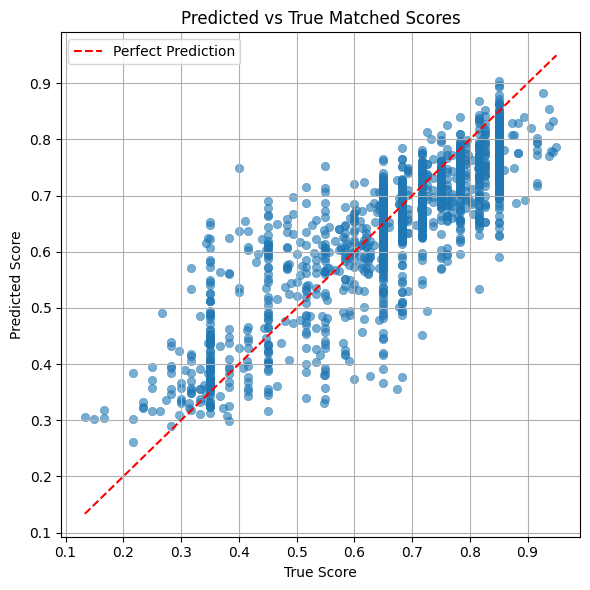

In [30]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=preds, alpha=0.6, edgecolor=None)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--', color='red', label="Perfect Prediction")
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs True Matched Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Residual Plot

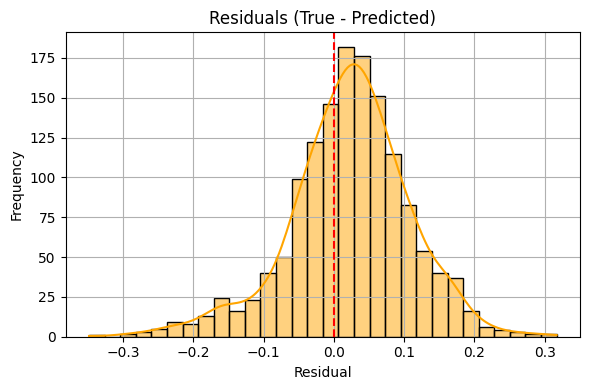

In [31]:
residuals = y_true - preds
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title("Residuals (True - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

Error Distribution Plot

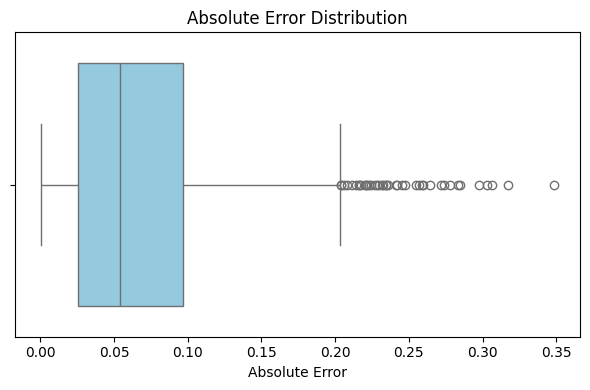

In [32]:
abs_errors = np.abs(y_true - preds)
plt.figure(figsize=(6, 4))
sns.boxplot(x=abs_errors, color='skyblue')
plt.title("Absolute Error Distribution")
plt.xlabel("Absolute Error")
plt.tight_layout()
plt.show()